In [23]:
import nest_asyncio
nest_asyncio.apply()

from hddCRP.simulations import simulate_sessions
from hddCRP.modelBuilder import cdCRP
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import arviz as az

In [24]:
seed = 1004
stan_seed = 1001
rng = np.random.Generator(np.random.MT19937(seed))

num_responses = 3
num_sessions = 1;
session_labels = ["A"] * num_sessions
session_lengths = [100] * num_sessions

alpha = 5
different_context_weights = [0.5, 0.5];
within_session_timescales  = {"A" : 20}
between_session_timescales = {("A","A") : 2}
repeat_bias_1_back = 1


seqs = simulate_sessions(session_lengths=session_lengths, session_labels=session_labels, num_responses=num_responses, 
                         alpha=alpha,
                         different_context_weights=different_context_weights,
                         within_session_timescales=within_session_timescales, between_session_timescales=between_session_timescales,
                         repeat_bias_1_back=repeat_bias_1_back, rng=rng)
print(seqs)

# rng = np.random.Generator(np.random.MT19937(seed))
# within_session_timescales  = {"A" : 60}
# seqs = simulate_sessions(session_lengths=session_lengths, session_labels=session_labels, num_responses=num_responses, 
#                          alpha=alpha,
#                          different_context_weights=different_context_weights,
#                          within_session_timescales=within_session_timescales, between_session_timescales=between_session_timescales,
#                          repeat_bias_1_back=repeat_bias_1_back, rng=rng)
# print(seqs)

[array([2, 2, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 2, 1, 2, 1,
       0, 2, 2, 0, 2, 0, 0, 1, 2, 2, 1, 2, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1,
       2, 0, 0, 1, 0, 2, 2, 1, 2, 2, 2, 2, 1, 1, 1, 0, 1, 2, 2, 0, 2, 2,
       0, 1, 0, 0, 0, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2, 0, 1, 2, 2, 1, 2, 0,
       1, 2, 2, 2, 0, 1, 2, 1, 1, 2, 2, 2, 0, 1, 2, 2, 2, 0, 0, 0, 2, 2,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 1, 0, 2, 2, 2, 1, 1,
       0, 2, 2, 0, 2, 1, 1, 2, 2, 2, 2, 1, 2, 0, 1, 1, 2, 1, 1, 0, 2, 1,
       1, 0, 1, 1, 2, 2, 2, 0, 1, 1, 2, 2, 1, 0, 0, 2, 2, 2, 2, 2, 2, 1,
       2, 1, 2, 1, 2, 1, 2, 0, 2, 0, 1, 2, 2, 0, 2, 0, 2, 2, 0, 1, 1, 2,
       0, 0])]


In [25]:
model = cdCRP(seqs);
model.same_nback_depth = 0
model.context_depth = len(different_context_weights)

In [26]:
fit = model.fit_model(random_seed=stan_seed);
print(model.fit_summary())

Building...


Building: found in cache, done.Messages from stanc:
    means either no prior is provided, or the prior(s) depend on data
    variables. In the later case, this may be a false positive.
    either no prior is provided, or the prior(s) depend on data variables. In
    the later case, this may be a false positive.
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   6% (500/8000)
Sampling:   8% (600/8000)
Sampling:   9% (700/8000)
Sampling:  10% (800/8000)
Sampling:  11% (900/8000)
Sampling:  12% (1000/8000)
Sampling:  14% (1100/8000)
Sampling:  15% (1200/8000)
Sampling:  16% (1300/8000)
Sampling:  18% (1400/8000)
Sampling:  19% (1500/8000)
Sampling:  20% (1600/8000)
Sampling:  21% (1700/8000)
Sampling:  22% 

                                 mean      sd  hdi_3%  hdi_97%  mcse_mean  \
alpha                          11.804   6.581   2.415   24.247      0.118   
timeconstant_within_session_A  33.006  28.047   1.618   84.403      0.499   
context_similarity_depth_1      0.470   0.263   0.046    0.947      0.004   

                               mcse_sd  ess_bulk  ess_tail  r_hat  
alpha                            0.084    2804.0    2054.0    1.0  
timeconstant_within_session_A    0.361    2879.0    2885.0    1.0  
context_similarity_depth_1       0.003    3479.0    2503.0    1.0  


In [27]:
fit_df = fit.to_frame()
print(fit_df["alpha"].median())
#print(fit_df["context_similarity_depth_1"].median())
#print(fit_df["context_similarity_depth_2"].median())
print(fit_df["timeconstant_within_session_A"].median())
#print(fit_df["repeat_bias_1_back"].median())

10.328967768905496
24.31935409327392


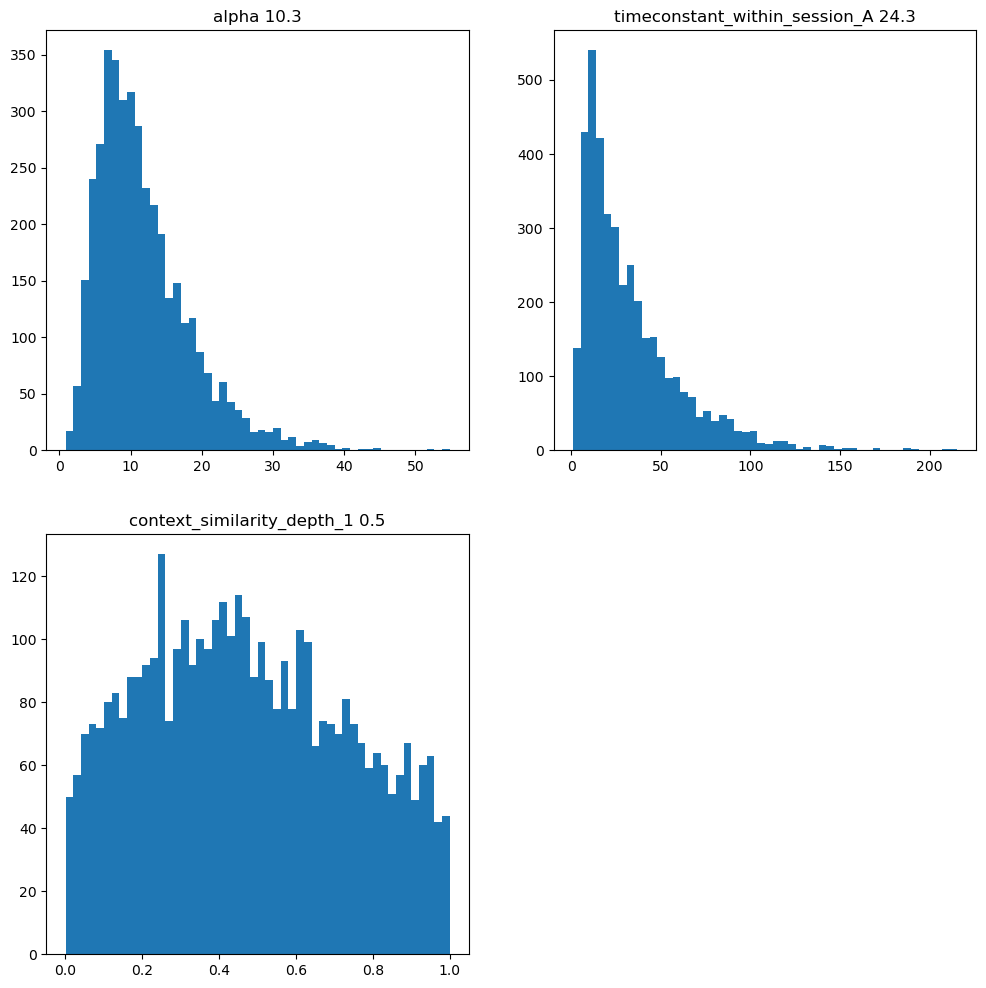

In [28]:
plt.figure(figsize=(12,12))
plt.subplot(2,2,1)
ff = "alpha";
plt.hist(fit_df[ff],50);
plt.title('{0} {1:.1f}'.format(ff,fit_df[ff].median()))
plt.subplot(2,2,2)
ff = "timeconstant_within_session_A";
plt.hist(fit_df[ff],50);
plt.title('{0} {1:.1f}'.format(ff,fit_df[ff].median()))
for ii in range(1,model.context_depth+1):
    plt.subplot(2,2,2+ii)
    ff = f"context_similarity_depth_{ii}";
    plt.hist(fit_df[ff],50);
    plt.title('{0} {1:.1f}'.format(ff,fit_df[ff].median()))


In [29]:
print(model.model)


data {
    int N; // Number of data points
    int M; // number of possible observations
    array[N] int Y;
    array[N] int local_timeconstant_id;
    array[N] int session_id;
    array[N] real local_time;

    real prior_alpha_shape;
    real prior_alpha_scale;
    real prior_timeconstant_within_session_shape;
    real prior_timeconstant_within_session_scale;
    matrix[N,N] is_same_context_1;
    real prior_context_similarity_depth_1_alpha;
    real prior_context_similarity_depth_1_beta;
}

transformed data {
    // variables to turn main computation in matrix operations
    vector[N] vs = rep_vector(1, N);

    matrix[N,N] is_same_observation = rep_matrix(0, N, N); // for numerator in CRP likelihood p(y_t | y_1:t-1)
    matrix[N,N] is_prev_observation = rep_matrix(0, N, N); // for denominator in CRP likelihood p(y_t | y_1:t-1)
    for (aa in 1:N) {
        for (bb in 1:N) {
            if(local_time[bb] < local_time[aa]) {
                is_prev_observation[aa,bb] = 1;
         

In [30]:
t = fit["timeconstant_within_session_A"]
a = fit["alpha"]
print(str(t.mean()) + "\t" + str(t.var()))
print(str(a.mean()) + "\t" + str(a.var()))

model.to_dict()["Y"]

33.00623677608137	786.4593908490652
11.804084056944244	43.30047995394427


array([3, 3, 1, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 1, 3, 2, 3, 2,
       1, 3, 3, 1, 3, 1, 1, 2, 3, 3, 2, 3, 1, 3, 1, 3, 3, 3, 2, 2, 2, 2,
       3, 1, 1, 2, 1, 3, 3, 2, 3, 3, 3, 3, 2, 2, 2, 1, 2, 3, 3, 1, 3, 3,
       1, 2, 1, 1, 1, 2, 3, 3, 3, 1, 1, 1, 3, 3, 3, 1, 2, 3, 3, 2, 3, 1,
       2, 3, 3, 3, 1, 2, 3, 2, 2, 3, 3, 3, 1, 2, 3, 3, 3, 1, 1, 1, 3, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 2, 1, 3, 3, 3, 2, 2,
       1, 3, 3, 1, 3, 2, 2, 3, 3, 3, 3, 2, 3, 1, 2, 2, 3, 2, 2, 1, 3, 2,
       2, 1, 2, 2, 3, 3, 3, 1, 2, 2, 3, 3, 2, 1, 1, 3, 3, 3, 3, 3, 3, 2,
       3, 2, 3, 2, 3, 2, 3, 1, 3, 1, 2, 3, 3, 1, 3, 1, 3, 3, 1, 2, 2, 3,
       1, 1])

56.95920815954194

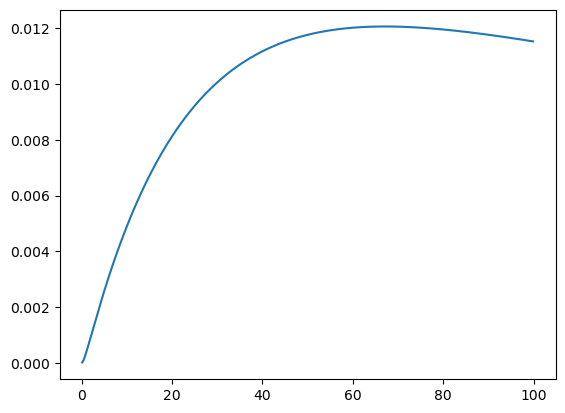

In [31]:
def lpdf(seq, alphas,M):
    seq = seq.flatten();
    n_prev = np.sum(np.tril(seq[:,np.newaxis] == seq[np.newaxis,:],-1),axis=1,keepdims=True);
    n_tot  = np.arange(0,n_prev.size)[:,np.newaxis]
    alphas = alphas.flatten()[np.newaxis,:];
    yy = np.log(n_prev + alphas/M) - np.log(n_tot + alphas);
    return yy.sum(axis=0);

alphas = np.arange(0.1,100,0.1);
yy = lpdf(model.to_dict()["Y"], alphas, model.M);

ww = np.exp(yy-np.max(yy));
ww = ww/(np.sum(ww)*0.1);
plt.plot(alphas,ww)

np.dot(ww,alphas)*0.1